In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
# import plotly.express as px
import os
from  scipy import ndimage
IMAGES_FOLDER_PATH = "../img"
import time

In [2]:
def display_img_arr(img_arr, r, c, dim,titles_arr):
    fl = 0
    fig = plt.figure(figsize = dim)
    for i in range(r):
        for j in range(c):
            if len(img_arr) == fl:
                break
            ax1 = fig.add_subplot(r, c, fl + 1)
            ax1.set_title(titles_arr[fl], fontsize = 20)
            ax1.imshow(img_arr[fl], cmap = 'gray')
            fl = fl + 1
    plt.show()
    
def read_img(im_names):
    im = []
    im_gray = []
    for name in im_names:
        img =  cv2.imread(IMAGES_FOLDER_PATH+'/'+name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if(len(im)==1):
            img = cv2.resize(img,(im[0].shape[0],im[0].shape[1]))
        im.append(img)
        im_gray.append(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    return im, im_gray

In [3]:
img3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'img5.png'))
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img3_gray = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'img5.png'),0)
tri3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'tri5.png'),0)


new_bg3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'new_bg1.jpeg'))
new_bg3 = cv2.cvtColor(new_bg3, cv2.COLOR_BGR2RGB)
new_bg3 = cv2.resize(new_bg3, (img3.shape[1],img3.shape[0])) 

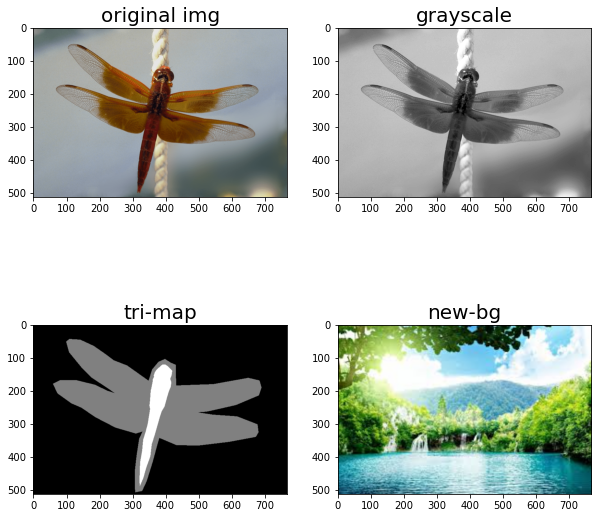

In [4]:
display_img_arr([img3,img3_gray,tri3,new_bg3], 2,2,(10,10), ['original img','grayscale','tri-map','new-bg'])

# Global Matting

Poisson Equation
$$\Delta \alpha = div (\frac{\nabla I}{F-B})$$
where, $\Delta = (\frac{\partial^2}{\partial x^2},\frac{\partial^2}{\partial y^2})$
is Laplacian Operator and div is divergence opertor


We solve this Poisson Equation using Gauss Siedel Iteration with overrealaxation method which is,

Given,  $$ \frac{\partial^2 f}{\partial x^2}+\frac{\partial^2 f}{\partial y^2} = S$$
$$ {f_{i,j}}^{(n+1)} = \frac{\beta}{4}({f_{i+1,j}}^{(n)} + {f_{i-1,j}}^{(n+1)}) + {f_{i,j+1}}^{(n)} + {f_{i,j-1}}^{(n+1)} - S_{i,j}) + (1-\beta){f_{i,j}}^{(n)}$$
where, $\beta$ lies in the range (1,2)



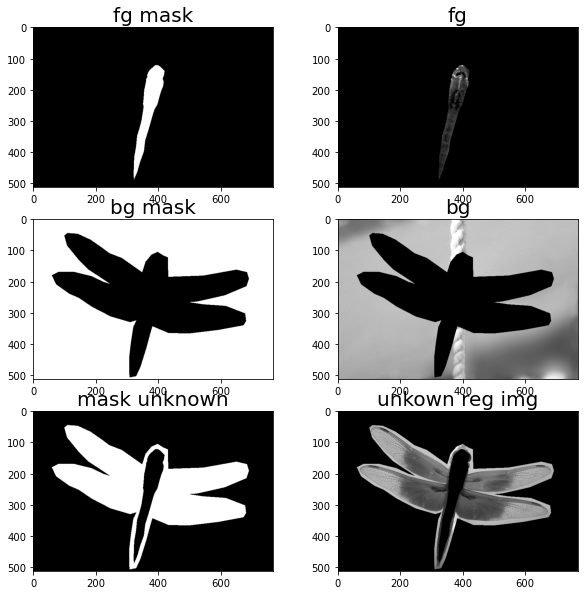

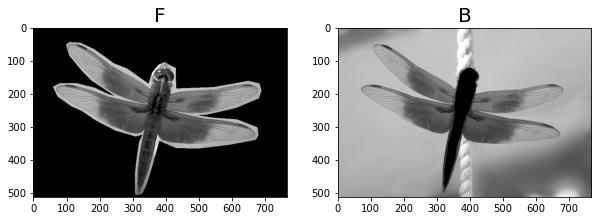

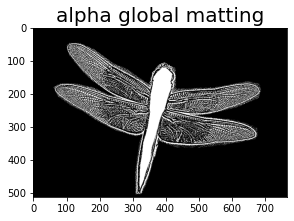

In [5]:
def calc_masks(tri3, img3_gray):
    mask_bg = (tri3<10)
    mask_fg = (tri3>245)
    mask_unknown = (np.bitwise_and(tri3>=10,tri3<=245))

    fg = img3_gray*(mask_fg)
    bg = img3_gray*(mask_bg)
    unknown = img3_gray*mask_unknown
    return [mask_fg,fg,mask_bg,bg,mask_unknown,unknown], ['fg mask','fg','bg mask','bg','mask unknown','unkown reg img']

def doubleDifferential(img, factor):
    dy, dx = np.gradient(img)
    d2y, _ = np.gradient(dy/factor)
    _, d2x = np.gradient(dx/factor)
    return d2y, d2x
    
    
def fb(img3_gray,mask_fg,mask_bg,mask_unknown):
    F = img3_gray*(mask_fg+mask_unknown)
    B = img3_gray*(mask_bg+mask_unknown)
    return F, B

def global_alpha_matting(alpha,d2alpha,unknown_seg,iters = 50, threshold = 0.1, beta = 1):
    tic = time.time()
    prev_alpha = np.zeros(alpha.shape)
    diff = np.sum(np.abs(prev_alpha-alpha))
    
    for _ in range(iters):
        diff = np.sum(np.abs(prev_alpha-alpha))
        if diff < threshold:
            break
        for i in range(1,alpha.shape[0]-1):
            for j in range(1,alpha.shape[1]-1):
                if unknown_seg[i,j]!=0 :
                    alpha[i,j] = ((beta*(alpha[i,j-1]+alpha[i-1,j]+prev_alpha[i,j+1]+prev_alpha[i+1,j] - d2alpha[i,j])/4) + (1-beta)*prev_alpha[i,j])
    tac = time.time()                    
    return alpha, tac-tic

def grads(F,B,mask_fg,img3_gray,mask_unknown):
    diff = np.minimum(np.maximum(F-B,0),255)

    diff = ndimage.filters.gaussian_filter(diff, 0.9)
    diff = np.minimum(np.maximum(diff,0),255)
    grad_y,grad_x = np.gradient(img3_gray)
    diff[diff==0] = 1
    d2y_alpha, _ = np.gradient(grad_y/diff)
    _, d2x_alpha = np.gradient(grad_x/diff)
    d2alpha = d2y_alpha + d2x_alpha
    estimate_alpha = mask_fg + 0.5*mask_unknown
    return estimate_alpha, d2alpha, diff

def func_estimate_alpha(tri3, img3_gray):
    imgs, titles = calc_masks(tri3, img3_gray)
    display_img_arr(imgs, 3,2,(10,10),titles)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
    
    F,B = fb(img3_gray,mask_fg,mask_bg,mask_unknown)
    display_img_arr([F,B], 1,2,(10,10),['F','B'])
#     print(mask_fg.shape,fg.shape,mask_bg.shape,bg.shape,mask_unknown.shape,unknown.shape,F.shape,B.shape,img3_gray.shape)
    est_alpha, d2alpha, diff =  grads(F,B,mask_fg,img3_gray,mask_unknown)
    return est_alpha, F, B, d2alpha, imgs, diff

def matting_combined(tri3, img3_gray):
    estimate_alpha, F, B, d2alpha, imgs, diff = func_estimate_alpha(tri3, img3_gray)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
    alpha, _ = global_alpha_matting(estimate_alpha,d2alpha,mask_unknown)
    alpha = np.minimum(np.maximum(alpha,0),1)

    return {'alpha': alpha, 'F':F, 'B': B, 'diff': diff, 'unknown': unknown, 'mask_unknown': mask_unknown}

#     return alpha
# alpha = matting_combined(tri3, img3_gray)
all_data = matting_combined(tri3, img3_gray)
## adding images also to this all_data
all_data.update({'img3': img3, 'img3_gray': img3_gray})

## NOW all_data VARIABLE CONTAINS IMG3, IMG3_GRAY, ALPHA, DIFF, F, B, UNKNOWN


# display_img_arr([new_img ], 1,1,(10,10),['img with new bg'])

display_img_arr([all_data['alpha']], 1,2,(10,10),['alpha global matting'])


# Alpha blending

### I = α F + (1 − α )B

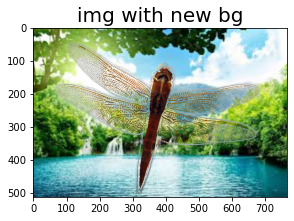

In [6]:
def alpha_blend(new_bg3,alpha,img3 ):
    new_img = np.zeros(new_bg3.shape)
    new_img[:,:,0] = alpha*img3[:,:,0] + (1-alpha)*new_bg3[:,:,0]
    new_img[:,:,1] = alpha*img3[:,:,1] + (1-alpha)*new_bg3[:,:,1]
    new_img[:,:,2] = alpha*img3[:,:,2] + (1-alpha)*new_bg3[:,:,2]
    return np.int64(new_img)

new_img = alpha_blend(new_bg3,all_data['alpha'],img3)
display_img_arr([new_img ], 1,2,(10,10),['img with new bg'])

##  Computationally efficient version of Global alpha matting

In [7]:
def optimal_alpha_matting(alpha, d2alpha, unknown):
    tic = time.time()
    new_alpha = alpha.copy()
    old_alpha = np.zeros(alpha.shape)
    h, w = img3_gray.shape
    threshold = 0.001
    iters = 50
    non_zero = np.nonzero(unknown)
    c_alpha = np.transpose(non_zero)
    c = c_alpha[(c_alpha[:,0]>=1)&(c_alpha[:,0]<h-1)&(c_alpha[:,1]>=1)&(c_alpha[:,1]<w-1)]
    first = c[:,0]
    second = c[:,1]
    diff = np.sum(np.abs(new_alpha - old_alpha))
    for i in range(iters):
        old_alpha = new_alpha.copy()
        new_alpha[first,second] = new_alpha[first-1 ,second]
        new_alpha[first,second] = new_alpha[first,second] 
        new_alpha[first,second] += new_alpha[first,second-1]
        new_alpha[first,second] += old_alpha[first, second+1] 
        new_alpha[first,second] += old_alpha[first+1,second]
        new_alpha[first,second] -= d2alpha[first,second]
        new_alpha[first,second] *= 1/4
        diff = np.sum(np.abs(new_alpha - old_alpha))
        if(diff < threshold):
            break
    tac = time.time()
    return new_alpha, tac-tic

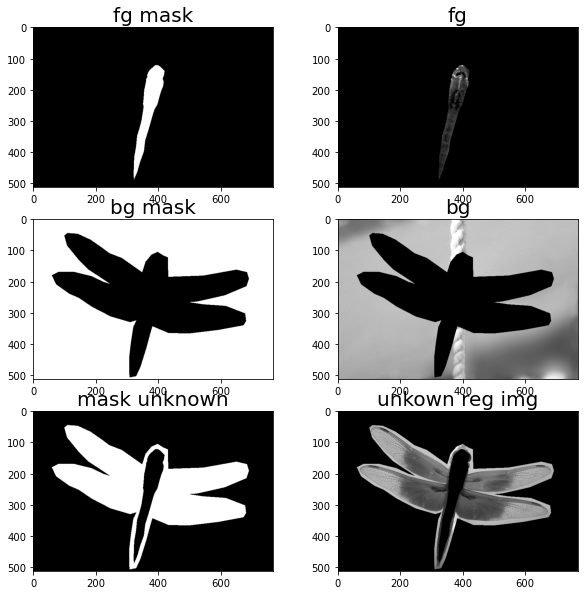

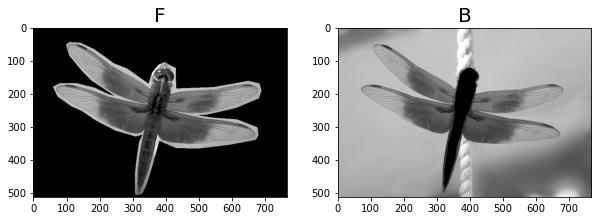

In [ ]:
import time
def matting(tri3, img3_gray,type_matting):
    estimate_alpha, F, B, d2alpha, imgs, diff = func_estimate_alpha(tri3, img3_gray)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
    if(type_matting=='noneff'):
        alpha, time = global_alpha_matting(estimate_alpha,d2alpha,mask_unknown, iters= 50, threshold = 0.3, beta = 1.5)
    else:
        alpha, time = optimal_alpha_matting(estimate_alpha, d2alpha, mask_unknown)
    alpha = np.minimum(np.maximum(alpha,0),1)
    return alpha, time

alpha,time_non_eff = matting(tri3, img3_gray,'noneff')
alpha_o,time_o = matting(tri3, img3_gray,'eff')
print("non-eff version time",time_non_eff)
print("eff version time",time_o)

In [ ]:
display_img_arr([alpha, alpha_o ], 1,2,(10,10),['non-eff alpha','eff alpha'])

In [ ]:
#alpha blending  
new_img = alpha_blend(new_bg3,alpha,img3 )
display_img_arr([new_img], 1,2,(10,10),['new image'])

## Local Matting

In [ ]:
# get ROI from Select_roi.py

!python3 Select_roi.py ../img/img5.png
#returns top, left, bottom, right
# Select region where matte to be improved, after selecting type "quit"
#coords selected are saved in coords.txt file

In [ ]:
!python3 Select_roi.py ../img/img5.png
def read_coords():
    f = open('coords.txt','r')
    coords = f.read()
    f.close()
    # converting to int
    coord_int = []
    coords_i = coords.split(' ')
    for c in coords_i:
        if(c!=''):
            coord_int.append(int(c))
    return coord_int
coords =  read_coords() 
print(coords)
left, top,right, bottom = coords

In [ ]:
def local_matting(data_dic, top, bottom, left, right):
    h, w = data_dic['alpha'].shape[0], data_dic['alpha'].shape[1]
    local = 0
    if('local_matte' in data_dic.keys()):
        local = 1
        h, w = data_dic['local_matte'].shape[0], data_dic['local_matte'].shape[1]
        
    
    new_diff = data_dic['diff'][top:bottom+1, left:right+1]
    
    ## APPLYING GAUSSIAN FILTER ON THIS NEW DIFF
    new_diff = ndimage.filters.gaussian_filter(new_diff, 0.9)
    new_diff = np.minimum(np.maximum(new_diff,0),255)
    
    ## EXTRACTING SEGMENTS IN GIVEN RANGE FOR ORIGINAL IMAGE, FOREGROUND AND THE BACKGROUND
    required_img= data_dic['img3_gray'].copy()[top:bottom+1, left:right+1]
    required_fg = data_dic['F'].copy()[top:bottom+1,left:right+1]
    required_bg = data_dic['B'].copy()[top:bottom+1,left:right+1]
    required_unknown = data_dic['unknown'].copy()[top:bottom,left:right]
    required_alpha= data_dic['alpha'].copy()[top:bottom+1,left:right+1]
    if(local==1):
        required_alpha= data_dic['local_matte'].copy()[top:bottom+1,left:right+1]
    
    required_inverted_alpha= 1 - required_alpha
    required_mask_unknown = data_dic['mask_unknown'].copy()[top:bottom+1, left:right+1]
    
    
    ## GET DOUBLE DIFFERENTIAL FOR IMG, FOREGROUND AND BACKGROUND
    fg_d2y, fg_d2x = doubleDifferential(required_fg, new_diff)
    bg_d2y, bg_d2x = doubleDifferential(required_bg, new_diff)
    img_d2y, img_d2x = doubleDifferential(required_img, new_diff)
    weighted_fg = required_alpha*(fg_d2x+fg_d2y)
    weighted_bg = required_alpha*(bg_d2x+bg_d2y)
    new_d2alpha = img_d2x + img_d2y - weighted_fg - weighted_bg
    

#     display_img_arr([data_dic['alpha']], 1,2,(10,10),['alpha'])
    matte, time = global_alpha_matting(required_alpha,new_d2alpha,required_mask_unknown, iters= 50, threshold = 0.1, beta = 0.2)
#     display_img_arr([data_dic['alpha'],data_dic['mask_unknown']], 1,2,(10,10),['alpha','mask unkwon'])
    matte = np.minimum(np.maximum(matte,0),1)
    
    
#     matte, _= optimal_alpha_matting(required_alpha, new_d2alpha, required_unknown)

    return matte
all_data_2 = all_data.copy()
local_matte =  all_data_2['alpha'].copy()
# print(local_matte.shape)

# selecting regions which we feel are not correct in matte

local_matte[top:bottom+1, left:right+1] = local_matting(all_data_2.copy(), top, bottom, left, right)
all_data_2['local_matte'] = local_matte
top,bottom,left,right = [400,420,90,110]
local_matte[top:bottom+1, left:right+1] = local_matting(all_data_2.copy(), top, bottom, left, right)
# top, bottom, left, right = [280, 400, 80, 100]
# data_dic['alpha'] = local_matte
# local_matte[top:bottom+1, left:right+1] = local_matting(data_dic, top, bottom, left, right)
    
# local_matte = np.minimum(np.maximum(local_matte,0),1)
display_img_arr([local_matte], 1,2,(10,10),['local matte'])

### Local Poisson Matting vs Global Matting 

In [ ]:
new_img_local = alpha_blend(new_bg3,local_matte,img3)
display_img_arr([new_img_local], 1,2,(10,10),['img with new bg using local matting'])
display_img_arr([new_img], 1,2,(10,10),['img with new bg using global matting'])


## Combining  multiple bg's

In [ ]:
bg_names = ['jungle_bg.jpeg','foggy.png','new_bg1.jpeg','new_bg3.jpg']
bgs,bgs_g = read_img(bg_names)
display_img_arr(bgs, 1,4,(10,10),bg_names)

In [ ]:
def resize_im(images):
    new_imgs = []
    for i in images:
        new_imgs.append(cv2.resize(i,(images[0].shape[0],images[0].shape[1])))
    return new_imgs


In [ ]:
# generate image in new bgs
new_imgs = []
for bg in bgs:
    bg = cv2.resize(bg, (img3.shape[1],img3.shape[0]))
    new_imgs.append(alpha_blend(bg,alpha,img3 ))
    

display_img_arr(new_imgs, 2,2,(10,10),bg_names)    

In [ ]:
# saving imgages
for i,im in enumerate(new_imgs):
    plt.imsave(IMAGES_FOLDER_PATH+'/'+'new_img'+str(i)+'.png',im.astype('uint8'))

## High pass

In [ ]:
def convolve(img,kernel):
    h,w = img.shape
    k_h,k_w = kernel.shape
    
    output = np.zeros([h,w])
    
    padding_img = np.zeros([h+k_h-1,w+k_w-1])
    padding_img[int((k_h-1)/2):int(h+(k_h-1)/2),int((k_w-1)/2):int(w+(k_w-1)/2)] = img
    
    for i in range(k_h,h+k_h):
        for j in range(k_w,w+k_w):
            area_obs = padding_img[i-k_h:i,j-k_w:j]
            val = sum(sum(kernel*area_obs))
            output[i-k_h,j-k_w] = max(0,val)

    
    return np.int64(output)

def highboost(alpha,img,F,B,unknown_seg):
    
    k = 5
    
    gaussian_kernel = np.zeros([k,k])
    
    center = int((k-1)/2)
    sigma_s = 5
    
    for i in range(k):
        for j in range(k):
            gaussian_kernel[i][j] = np.exp(-(((i - center)**2 + (j-center)**2) / (2 * sigma_s * sigma_s)))
    
    grad_y,grad_x = np.gradient(img)
    
    D_y = convolve(grad_y,gaussian_kernel)
    D_x = convolve(grad_x,gaussian_kernel)
    
    diff = np.minimum(np.maximum(F-B,0),255)

    diff = ndimage.filters.gaussian_filter(diff, 0.9)
    diff = np.minimum(np.maximum(diff,0),255)

    diff[diff==0] = 1
    d2y_alpha, _ = np.gradient((grad_y-D_y)/diff)
    _, d2x_alpha = np.gradient((grad_x-D_x)/diff)

    alpha, _ = optimal_alpha_matting(alpha, d2alpha, unknown_seg)
    alpha = np.minimum(np.maximum(alpha,0),1)
    
    return alpha

estimate_alpha, F, B, d2alpha, imgs, diff= func_estimate_alpha(tri3, img3_gray)
mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
high_pass_alpha = highboost(estimate_alpha,img3_gray,F,B,mask_unknown) 
display_img_arr([high_pass_alpha], 2,2,(10,10),['high pass alpha'])    

# Refinement

### Local high pass

In [ ]:
'''
Local High Pass Filter
'''
import scipy
def high_pass(all_data,top, bottom, left, right):
    h = all_data['alpha'].copy().shape[0]
    w =  all_data['alpha'].copy().shape[1]
    alpha_matte = all_data['alpha'].copy()
    local_matte = np.zeros((h,w))
    diff_2 = all_data['diff'].copy()[top:bottom+1,left:right+1]
    diff_2 = scipy.ndimage.filters.gaussian_filter(diff_2, 0.9)
    
    segmented_fg = all_data['F'].copy()[top:bottom+1,left:right+1]
    dyfg, dxfg = np.gradient(segmented_fg)
    yfg_n = dyfg/diff_2
    d2yfg, _ = np.gradient(yfg_n)
    xfg_n = dxfg/diff_2
    _, d2xfg = np.gradient(xfg_n)
    
    segmented_bg = all_data['B'].copy()[top:bottom+1,left:right+1]
    dybg, dxbg = np.gradient(segmented_bg)
    ybg_n = dybg/diff_2
    d2ybg, _ = np.gradient(ybg_n)
    xbg_n = dxbg/diff_2
    _, d2xbg = np.gradient(xbg_n)
    
    seg = all_data['img3_gray'].copy()[top:bottom+1,left:right+1]
    refined_D = cv2.GaussianBlur(seg,(3,3),0)
    dy, dx = np.gradient(seg)
    dy_normalized = dy/diff_2
    d2y, _ = np.gradient(dy_normalized)
    x_normalized = dx/diff_2
    _, d2x = np.gradient(x_normalized)
    segmented_bg = d2y + d2x - refined_D
 
    
    Estimate_alpha_seg = all_data['alpha'].copy()[top:bottom+1,left:right+1]
    D = (Estimate_alpha_seg*(d2yfg + d2xfg) + (1 - Estimate_alpha_seg)*(d2ybg+d2xbg))
    
    matte,_ = global_alpha_matting(Estimate_alpha_seg, segmented_bg,all_data['unknown'].copy()[top:bottom,left:right])
    
    return matte

'''
Boosting Brush
'''

def boosting(all_data,top, bottom, left, right):
    
    h, w = all_data['alpha'].copy().shape[0], all_data['alpha'].copy().shape[1]
    alpha_matte = all_data['alpha'].copy()
    local_matte = np.zeros((h,w))
    diff_2 = all_data['diff'].copy()[top:bottom+1,left:right+1]
    diff_2 = scipy.ndimage.filters.gaussian_filter(diff_2, 0.9)

    lambda_ = 5
    sigma = 20
    seg = all_data['img3_gray'].copy()[top:bottom+1,left:right+1]
    dy, dx = np.gradient(seg)
    dy_normalised = dy/diff_2
    d2y, _ = np.gradient(dy_normalised)
    dx_normalised = dx/diff_2
    _, d2x = np.gradient(dx_normalised)

    
    segmented_fg = all_data['F'].copy()[top:bottom+1,left:right+1]
    dyfg, dxfg = np.gradient(segmented_fg)
    yfg_n = dyfg/diff_2
    d2yfg, _ = np.gradient(yfg_n)
    xfg_n = dxfg/diff_2
    _, d2xfg = np.gradient(xfg_n)

    segmented_bg = all_data['B'].copy()[top:bottom+1,left:right+1]
    dybg, dxbg = np.gradient(segmented_bg)
    ybg_n = dybg/diff_2
    d2ybg, _ = np.gradient(ybg_n)
    xbg_n = dxbg/diff_2
    _, d2xbg = np.gradient(xbg_n)

    A = np.zeros((h,w))
    
    x0 = top + bottom - top +1/2
    y0 = left + right-left +1/2
    for x in range(top,bottom+1+1):
        for y in range(left,right+1+1):
            A[x,y] = (1 + lambda_*np.exp(-1*((abs(x-x0)**2+(abs(y-y0))**2))/(2*sigma**2)))*(1/all_data['diff'].copy()[x,y])
    diff_2 = 1/A[top:bottom+1,left:right+1]
    
    Estimate_alpha_seg = alpha_matte[top:bottom+1,left:right+1]
    
    D = (Estimate_alpha_seg*(d2yfg + d2xfg) + (1 - Estimate_alpha_seg)*(d2ybg+d2xbg))
    
    segmented_bg = d2y + d2x - D
    matte1,_ = global_alpha_matting(Estimate_alpha_seg, segmented_bg,all_data['unknown'].copy()[top:bottom,left:right])
    
    return matte1

'''
Performing Local Filter Operations on user selected regions and Obtaining the refined alpha Matte
'''

# selecting regions which we feel are not correct in matte
al_data_2 = all_data.copy()

local_matte = all_data_2['alpha'].copy()

top, bottom, left, right = [130,150,280,310]
all_data_2['local_matte'] = local_matte
local_matte[top:bottom+1,left:right+1] = boosting(all_data_2.copy(),top, bottom, left, right)


top, bottom, left, right = [300,330,0,90]
all_data_2['local_matte'] = local_matte
local_matte[top:bottom+1,left:right+1] = boosting(all_data_2.copy(),top, bottom, left, right)
local_matte = np.maximum(local_matte,0)
local_matte = np.minimum(local_matte,1)

h, w = all_data_2['alpha'].shape[0], all_data_2['alpha'].shape[1]
local_matte = local_matte.reshape(h,w)
display_img_arr([local_matte], 1,3,(16,40), ['refined matte'])

## Multi- background



In [ ]:
names = ['new_img0.png','new_img1.png','new_img2.png']
images,im_gray = read_img(names)
display_img_arr(images, 1,3,(16,40), names)

In [ ]:
img =  cv2.imread(IMAGES_FOLDER_PATH+'/'+'tri5.png',0)
tri = cv2.resize(img,(images[0].shape[1],images[0].shape[0]))
print(tri.shape,images[0].shape)
images = resize_im(images)
images[0] = cv2.resize(images[0],(images[1].shape[1],images[1].shape[0]))
images[1].shape

In [ ]:
# # gen trimap (for checking against bad quality trimaps)
# img =  cv2.imread(IMAGES_FOLDER_PATH+'/'+'tri3.png',0)
# tri = cv2.resize(img,(images[0].shape[0],images[0].shape[1]))
# kernel = np.ones((5,5),np.uint8)
# tri = cv2.erode(img,kernel,iterations = 2)
# display_img_arr([img,tri], 1,2,(16,16),['matte','eroded'] )

In [ ]:
# with multi-bg
T = 3
def calc_mean_img(T,alpha, B_arr,F):

    B_mean = np.zeros((B_arr[0].shape)).astype('float64')
    for i in range(T):
        B_mean += B_arr[i]
        display_img_arr([B_arr[i]], 1,2,(10,10),['B'+str(i+1)])
    B_mean /= T
    B_mean = B_mean.astype(np.uint8)
    
    mean_img = alpha*F+(np.ones((B_arr[0].shape))-alpha)*B_mean
    
    display_img_arr([F,B_mean,mean_img], 3,2,(10,10),['F','B_mean','mean img'] )
    return mean_img

def grads(F,B,mask_fg,img3_gray,mask_unknown):
    diff = np.minimum(np.maximum(F-B,0),255)
    diff = ndimage.filters.gaussian_filter(diff, 0.9)
    diff = np.minimum(np.maximum(diff,0),255)
    grad_y,grad_x = np.gradient(img3_gray)
    diff[diff==0] = 1
    d2y_alpha, _ = np.gradient(grad_y/diff)
    _, d2x_alpha = np.gradient(grad_x/diff)
    d2alpha = d2y_alpha + d2x_alpha
    estimate_alpha = mask_fg + 0.5*mask_unknown
    return estimate_alpha,d2alpha

def func_estimate_alpha(tri3, img3_gray,images):
    imgs, titles = calc_masks(tri3, img3_gray)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
    F,B = fb(img3_gray,mask_fg,mask_bg,mask_unknown)
    B_arr = [B]
    for i in range(1,T):
        if(i==1):
            images[i] = cv2.resize(images[i],(images[2].shape[1],images[2].shape[0]))
        _,B = fb(images[i],mask_fg,mask_bg,mask_unknown)
        B_arr.append(B)
#         display_img_arr([F,B], 1,2,(10,10),['F','B'])
#     print(mask_fg.shape,fg.shape,mask_bg.shape,bg.shape,mask_unknown.shape,unknown.shape,F.shape,B.shape,img3_gray.shape)
  
        
    est_alpha,d2alpha =  grads(F,B,mask_fg,img3_gray,mask_unknown)
    return est_alpha, F, B, B_arr, d2alpha, imgs
    

def matting_combined(tri3, img3_gray,images):
    estimate_alpha, F, B,B_arr, d2alpha,imgs = func_estimate_alpha(tri3, img3_gray,images)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
    
    alpha, _ = global_alpha_matting(estimate_alpha,d2alpha,mask_unknown, iters= 100, threshold = 0.01, beta = 1.2)
    alpha = np.minimum(np.maximum(alpha,0),1)
#     return alpha, d2alpha, B_arr
    return {'alpha': alpha, 'F':F, 'B': B, 'B_arr':B_arr, 'diff': diff, 'unknown': unknown, 'mask_unknown': mask_unknown,'img3_gray':img3_gray}

def mean_bg(tri,images):
    
    alpha_est,F,B,B_arr,d2alpha,imgs = func_estimate_alpha(tri, images[0],images)
#     alpha,d2_alpha, _ = matting_combined(tri, images[0],images)
    mean_img = calc_mean_img(3,alpha_est,B_arr ,F)
    all_data = matting_combined(tri, mean_img,images)
    !python3 Select_roi.py ../img/img5.png
    coords =  read_coords() 
    print("corrds selected: [left, top,right, bottom]",coords)
    left, top,right, bottom = coords

    local_matte = all_data['alpha'].copy()
    multi_bg_data = all_data.copy()
#     output = local_matting(all_data, top, bottom, left, right)
    local_matte[top:bottom+1, left:right+1] = local_matting(multi_bg_data, top, bottom, left, right)
    !python3 Select_roi.py ../img/img5.png
    coords =  read_coords() 
    print("corrds selected: [left, top,right, bottom]",coords)
    left, top,right, bottom = coords
    multi_bg_data['local_matte'] = local_matte
    local_matte[top:bottom+1, left:right+1] = local_matting(multi_bg_data, top, bottom, left, right)
    

    return local_matte, mean_img

local_alpha, mean_img = mean_bg(tri,np.array(im_gray))
display_img_arr([local_alpha], 1,2,(10,10),['local alpha mean bg'])
plt.show()